**Done:**
 - ...


**Doing:**
 - 1 pt: implement and test (convolutional) autoencoder, reporting the trend of reconstruction loss and some examples of image reconstruction
 - 1 pt: explore advanced optimizers and regularization methods
 - 1 pt: optimize hyperparameters using grid/random search and cross-validation
 - 1 pt: explore the latent space structure (e.g., PCA, t-SNE) and generate new samples from latent codes
 - 1 pt: implement and test denoising (convolutional) autoencoder
 - 2 pt: implement variational (convolutional) autoencoder or GAN
 
**Todo:**

- 1 pt: fine-tune the (convolutional) autoencoder using a supervised classification task (you can compare classification accuracy and learning speed with results achieved in homework 1)




In [1]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import tqdm # this module is useful to plot progress bars

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

### Set the random seed for reproducible results
torch.manual_seed(0)

Training device: cuda


# 1) Dataset

In [2]:
### Download the data and create dataset
data_dir = 'dataset'
# With these commands the train and test datasets, respectively, are downloaded 
# automatically and stored in the local "data_dir" directory.
train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

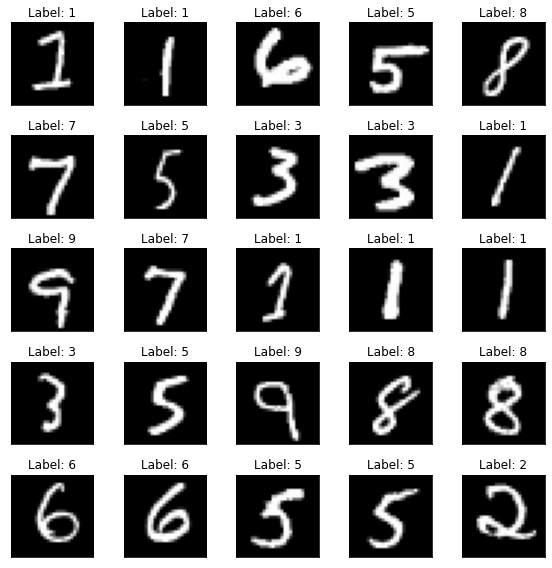

In [3]:
### Plot some sample
fig, axs = plt.subplots(5, 5, figsize=(8,8))
for ax in axs.flatten():
    # random.choice allows to randomly sample from a list-like object (basically anything that can be accessed with an index, like our dataset)
    img, label = random.choice(train_dataset)
    ax.imshow(np.array(img), cmap='gist_gray')
    ax.set_title('Label: %d' % label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

## 1.1) Dataset Transform

In [4]:
class noise(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, image):
        noise_factor=0.1*3
        noisy_img = image + noise_factor * torch.randn(image.shape)
        #clip the image
        noisy_img = np.clip(noisy_img, 0., 1.)

        return (image,noisy_img)

In [5]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    noise(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    noise(),
])

In [6]:
# Set the train transform
train_dataset.transform = train_transform
# Set the test transform
test_dataset.transform = test_transform

## 1.2) Dataloader

In [7]:
### Define train dataloader
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
### Define test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)

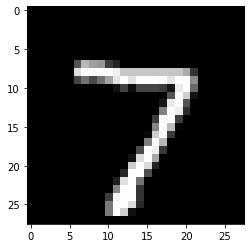

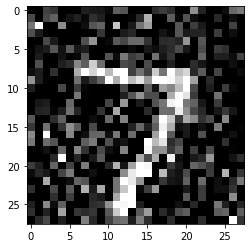

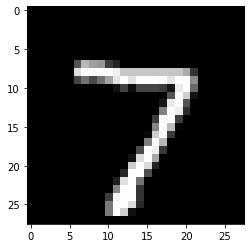

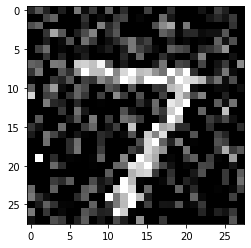

In [8]:
#Check if the transformation works
for image in test_dataloader:
    
    plt.imshow(image[0][0][0][0],cmap='gray')
    plt.show()
    plt.close()
    plt.imshow(image[0][1][0][0],cmap='gray')
    plt.show()
    plt.close()
    
    break


img=test_dataset[0][0][0].unsqueeze(0).to(device)
plt.imshow(img.cpu().squeeze().numpy(),cmap='gray')
plt.show()

img=test_dataset[0][0][1].unsqueeze(0).to(device)
plt.imshow(img.cpu().squeeze().numpy(),cmap='gray')
plt.show()


# 2) Model

## 2.1) Encoder

In [9]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim,dropout=0.5, conv1=8,conv2=16,conv3=32,fc=64):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(1, conv1, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Dropout2d(p=dropout),
            # Second convolutional layer
            nn.Conv2d(conv1, conv2, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Dropout2d(p=dropout),
            # Third convolutional layer
            nn.Conv2d(conv2, conv3, 3, stride=2, padding=0),
            nn.ReLU(True),
            nn.Dropout2d(p=dropout),
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)#dimension 0 is the sample, so we flatten from dimension 1

        ### Linear section
        self.encoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(3 * 3 * conv3, fc),
            nn.ReLU(True),
            nn.Dropout(p=dropout),
            # Second linear layer
            nn.Linear(fc, encoded_space_dim)
        )
        
    def forward(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        x = self.flatten(x)
        # # Apply linear layers
        x = self.encoder_lin(x)
        return x

## 2.2) Decoder

In [10]:
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim,dropout=0.5, conv1=8,conv2=16,conv3=32,fc=64):
        super().__init__()

        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(encoded_space_dim, fc),
            nn.ReLU(True),
            nn.Dropout(p=dropout),
            # Second linear layer
            nn.Linear(fc, 3 * 3 * conv3),
            nn.ReLU(True),
            nn.Dropout(p=dropout),
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(conv3, 3, 3))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(conv3, conv2, 3, stride=2, output_padding=0),
            nn.ReLU(True),
            nn.Dropout2d(p=dropout),
            # Second transposed convolution
            nn.ConvTranspose2d(conv2, conv1, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.Dropout2d(p=dropout),
            # Third transposed convolution
            nn.ConvTranspose2d(conv1, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Unflatten
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x

# 3) Train

## 3.1) Training Functions

In [11]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer,noise=False):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        
        image= image_batch[0].to(device)
        
        noisy=image    
        if noise: 
            noisy=image_batch[1].to(device)

        # Encode data
        encoded_data = encoder(noisy)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        #print('\t partial train loss (single batch): %f' % (loss.data))
    return loss.data

In [12]:
### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn,noise=False):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            image= image_batch[0].to(device)
        
            noisy=image
            
            if noise: 
                noisy=image_batch[1].to(device)
                
            # Encode data
            encoded_data = encoder(noisy)
            
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image.cpu())

        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [13]:
### Training cycle
def training_cycle(num_epochs,early_stopping,encoder,decoder,loss_fn,optim,train_dataloader,device,test_dataset,noise=False):
    train_loss_log = []
    val_loss_log = []

    max_early=float("-inf")
    idx_early=-1

    for epoch in range(num_epochs):
        #print('\t EPOCH %d/%d' % (epoch + 1, num_epochs))

        ### Training (use the training function)
        train_loss=train_epoch(
            encoder=encoder, 
            decoder=decoder, 
            device=device, 
            dataloader=train_dataloader, 
            loss_fn=loss_fn, 
            optimizer=optim,
            noise=noise)
        train_loss_log.append(train_loss)
        print('\t TRAIN - EPOCH %d/%d - loss: %f' % (epoch + 1, num_epochs, train_loss))

        ### Validation  (use the testing function)
        val_loss = test_epoch(
            encoder=encoder, 
            decoder=decoder, 
            device=device, 
            dataloader=test_dataloader, 
            loss_fn=loss_fn,
            noise=noise)
        val_loss_log.append(val_loss)
        print('\t VALIDATION - EPOCH %d/%d - loss: %f' % (epoch + 1, num_epochs, val_loss))

        ### Plot progress
        # Get the output of a specific image (the test image at index 0 in this case)
        img = test_dataset[0][0][0].unsqueeze(0).to(device)
        if noise: img = test_dataset[0][0][1].unsqueeze(0).to(device)
        encoder.eval()
        decoder.eval()
        with torch.no_grad():
            rec_img  = decoder(encoder(img))
        # Plot the reconstructed image
        fig, axs = plt.subplots(1, 2, figsize=(12,6))
        axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
        axs[0].set_title('Original image')
        axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
        axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch + 1))
        plt.tight_layout()
        plt.pause(0.1)
        # Save figures
        os.makedirs('autoencoder_progress_%d_features' % encoded_space_dim, exist_ok=True)
        fig.savefig('autoencoder_progress_%d_features/epoch_%d.jpg' % (encoded_space_dim, epoch + 1))
        plt.show()
        plt.close()

        # Save network parameters
        torch.save(encoder.state_dict(), 'encoder_params.pth')
        torch.save(decoder.state_dict(), 'decoder_params.pth')
        torch.save(optim.state_dict(), 'optim_params.pth')


        #Early stopping:
        if idx_early==-1:
            idx_early=epoch
            max_early=val_loss
        elif round(float(val_loss),3)<round(float(max_early),3):
            idx_early=epoch
            max_early=val_loss
            
        elif epoch-idx_early>=early_stopping:
            print("STOPPED BY EARLY STOPPYNG")
            break
    
    return (train_loss_log,val_loss_log)
    
    

## 3.2) Grid Search

Total Combinations: 1


Iteration: 0 (10, 8, 16, 32, 64, 0.001, 1e-05)
	 TRAIN - EPOCH 1/50 - loss: 0.065535
	 VALIDATION - EPOCH 1/50 - loss: 0.063994


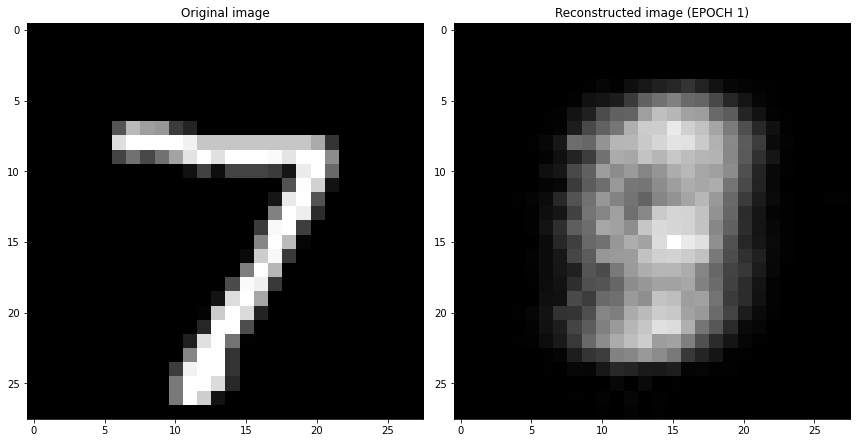

	 TRAIN - EPOCH 2/50 - loss: 0.054790
	 VALIDATION - EPOCH 2/50 - loss: 0.055942


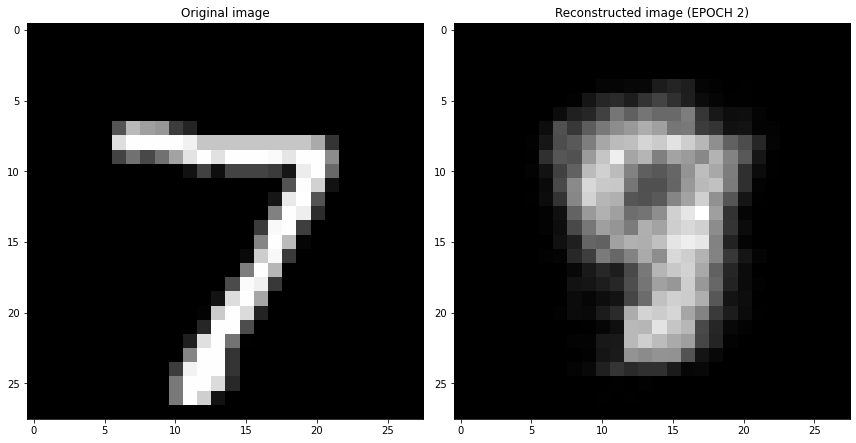

	 TRAIN - EPOCH 3/50 - loss: 0.046458
	 VALIDATION - EPOCH 3/50 - loss: 0.047174


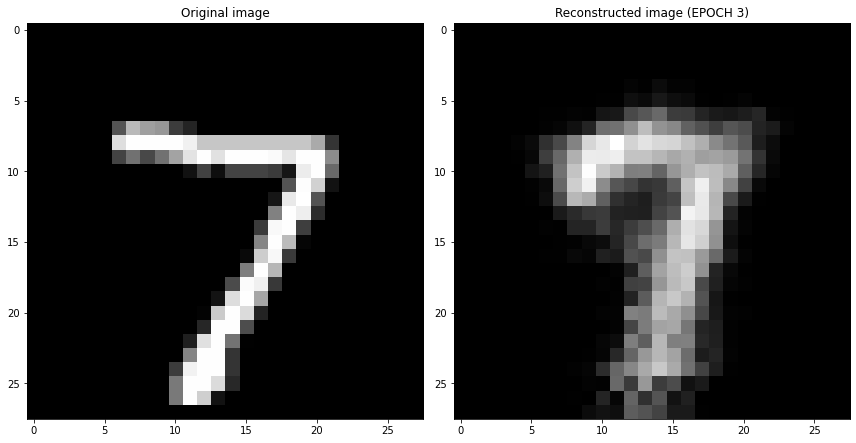

	 TRAIN - EPOCH 4/50 - loss: 0.037820
	 VALIDATION - EPOCH 4/50 - loss: 0.036280


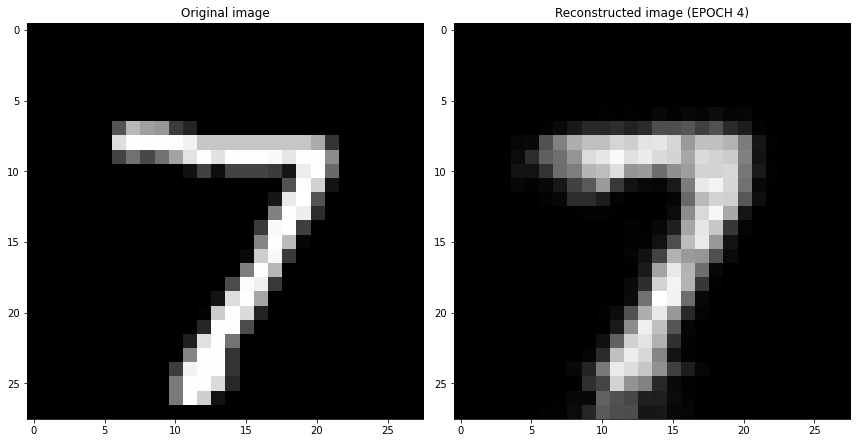

	 TRAIN - EPOCH 5/50 - loss: 0.027370
	 VALIDATION - EPOCH 5/50 - loss: 0.029369


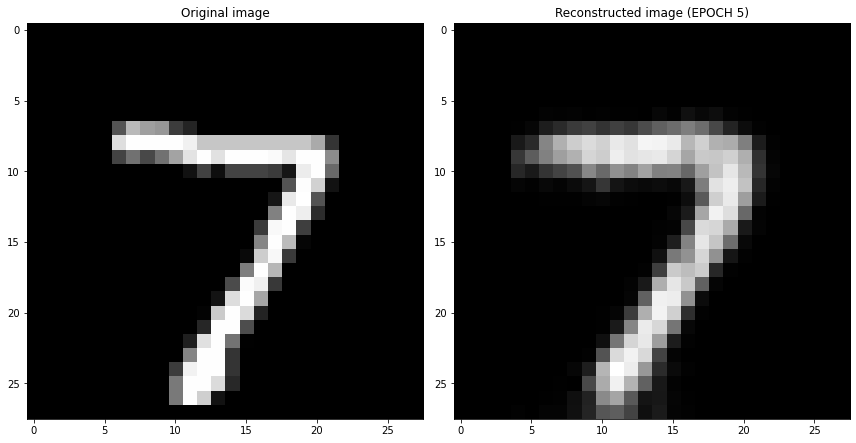

	 TRAIN - EPOCH 6/50 - loss: 0.026152
	 VALIDATION - EPOCH 6/50 - loss: 0.025712


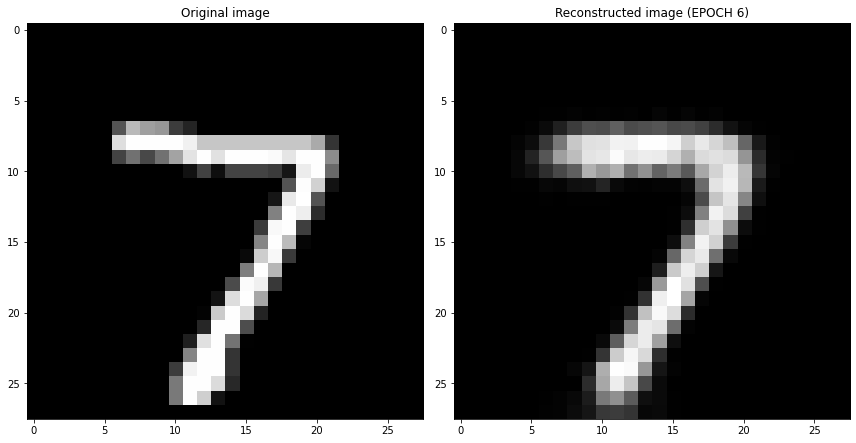

	 TRAIN - EPOCH 7/50 - loss: 0.024851
	 VALIDATION - EPOCH 7/50 - loss: 0.023935


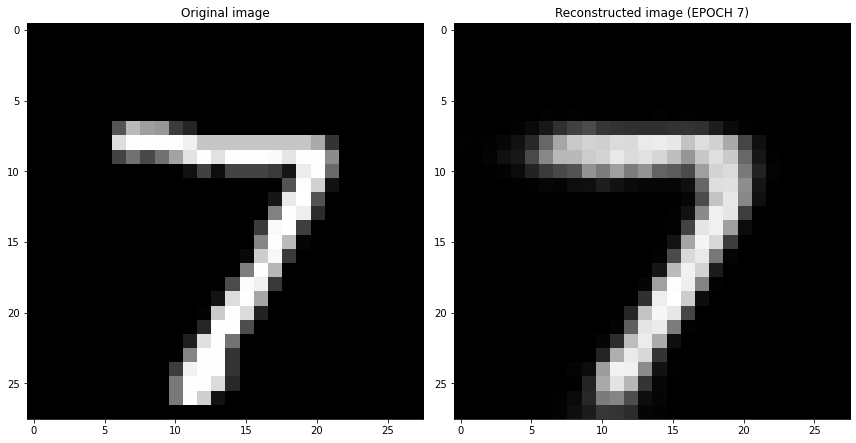

	 TRAIN - EPOCH 8/50 - loss: 0.023110
	 VALIDATION - EPOCH 8/50 - loss: 0.022889


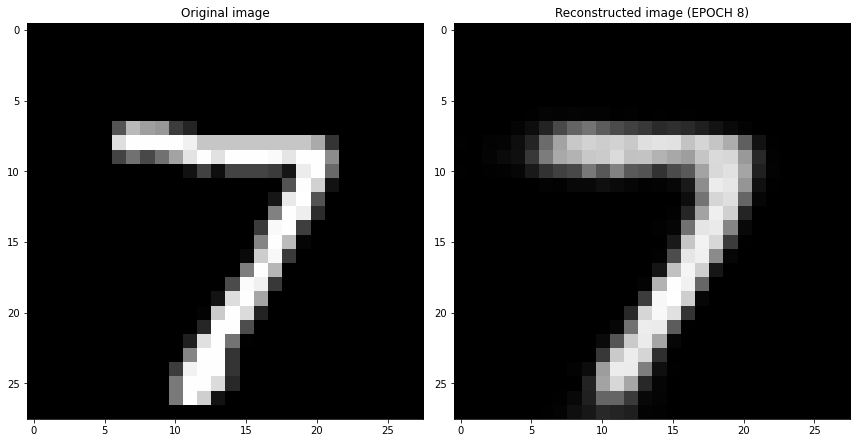

	 TRAIN - EPOCH 9/50 - loss: 0.023395
	 VALIDATION - EPOCH 9/50 - loss: 0.021607


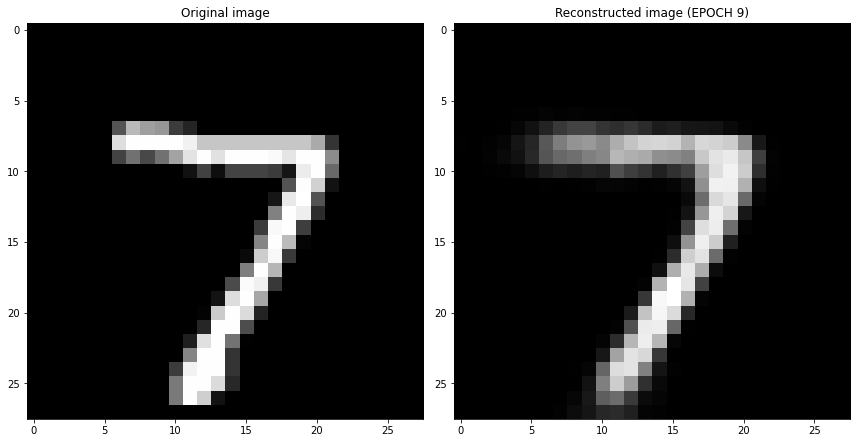

	 TRAIN - EPOCH 10/50 - loss: 0.019470
	 VALIDATION - EPOCH 10/50 - loss: 0.020275


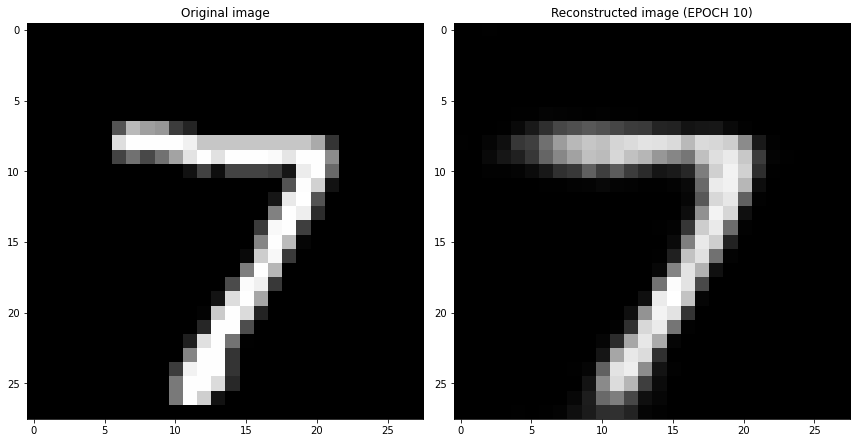

	 TRAIN - EPOCH 11/50 - loss: 0.019655
	 VALIDATION - EPOCH 11/50 - loss: 0.019461


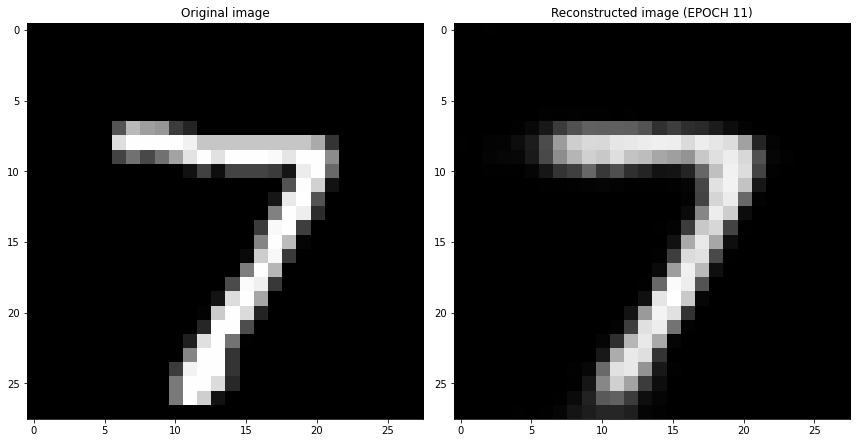

	 TRAIN - EPOCH 12/50 - loss: 0.018860
	 VALIDATION - EPOCH 12/50 - loss: 0.018970


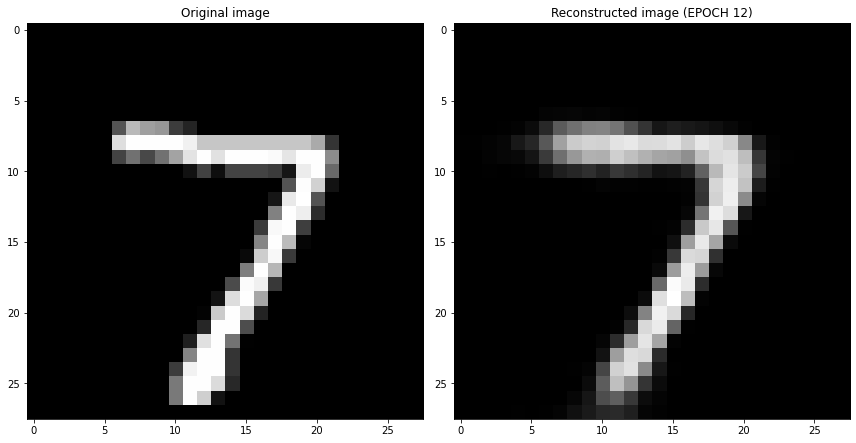

	 TRAIN - EPOCH 13/50 - loss: 0.019302
	 VALIDATION - EPOCH 13/50 - loss: 0.018379


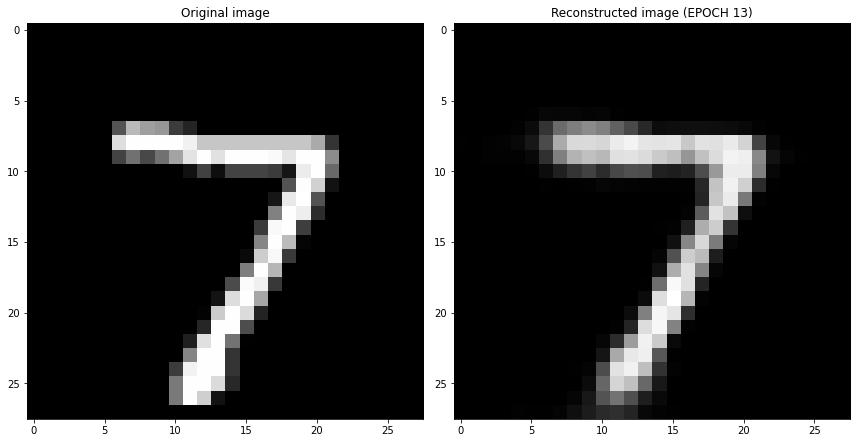

	 TRAIN - EPOCH 14/50 - loss: 0.019592
	 VALIDATION - EPOCH 14/50 - loss: 0.018049


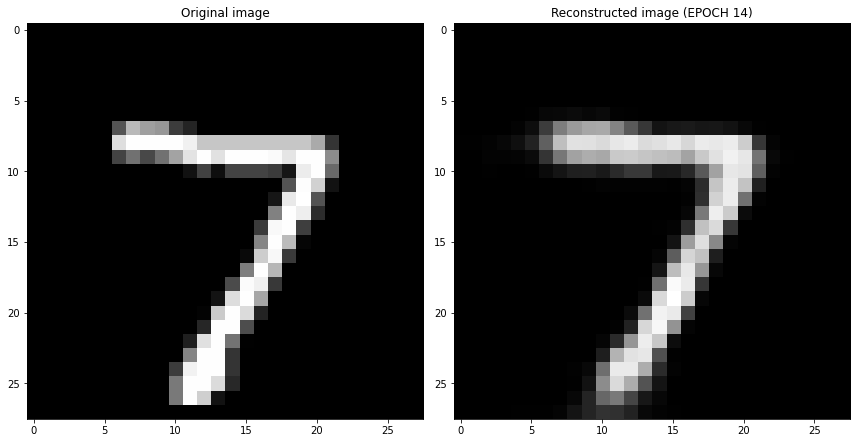

	 TRAIN - EPOCH 15/50 - loss: 0.017937
	 VALIDATION - EPOCH 15/50 - loss: 0.017633


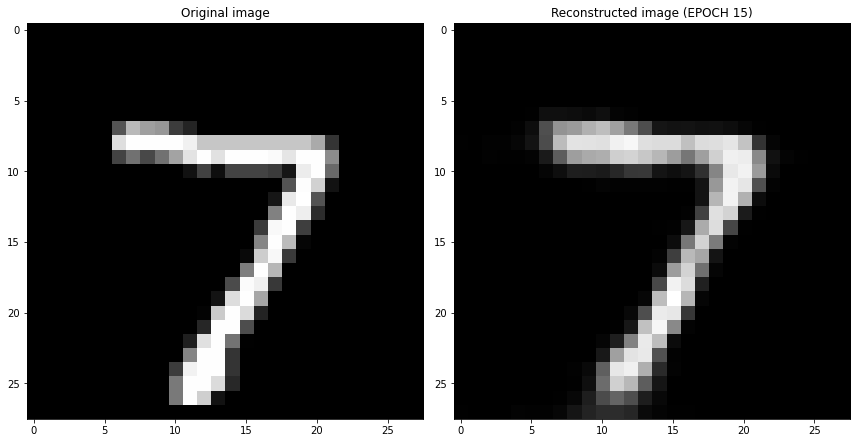

	 TRAIN - EPOCH 16/50 - loss: 0.016923
	 VALIDATION - EPOCH 16/50 - loss: 0.017428


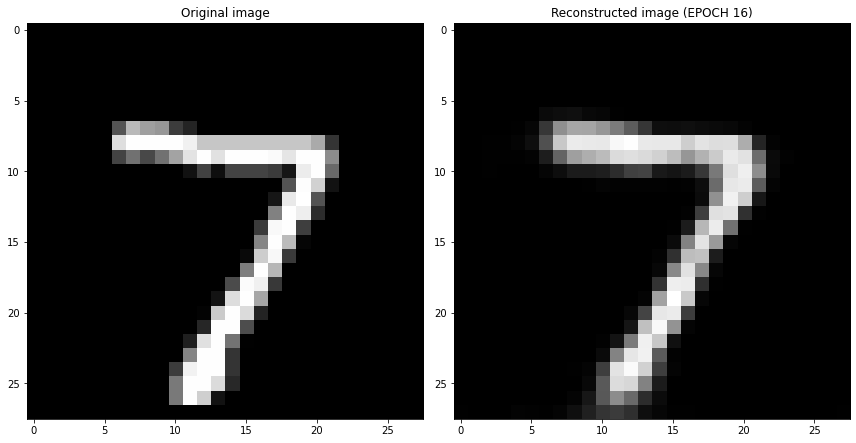

	 TRAIN - EPOCH 17/50 - loss: 0.014810
	 VALIDATION - EPOCH 17/50 - loss: 0.017038


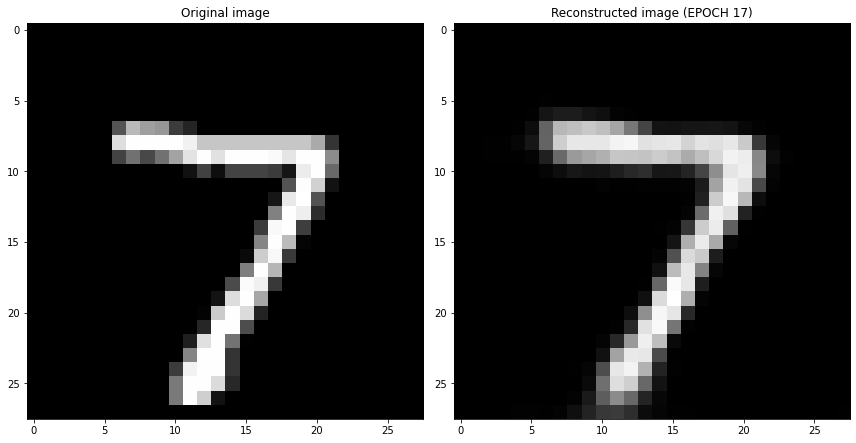

	 TRAIN - EPOCH 18/50 - loss: 0.016685
	 VALIDATION - EPOCH 18/50 - loss: 0.016856


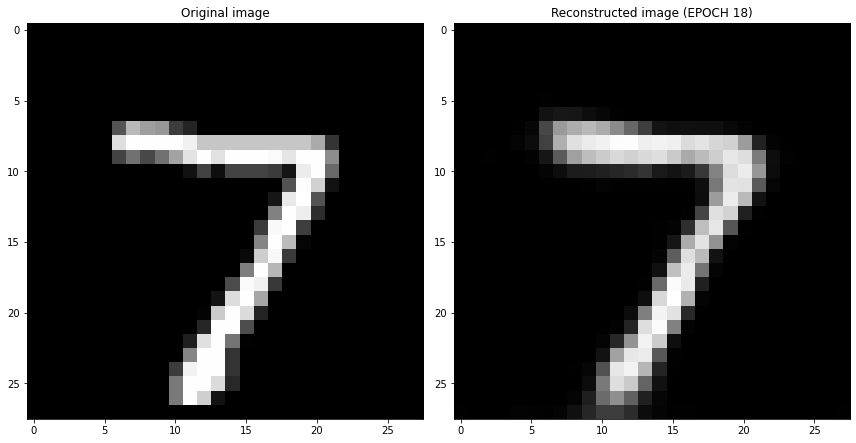

	 TRAIN - EPOCH 19/50 - loss: 0.016888
	 VALIDATION - EPOCH 19/50 - loss: 0.016849


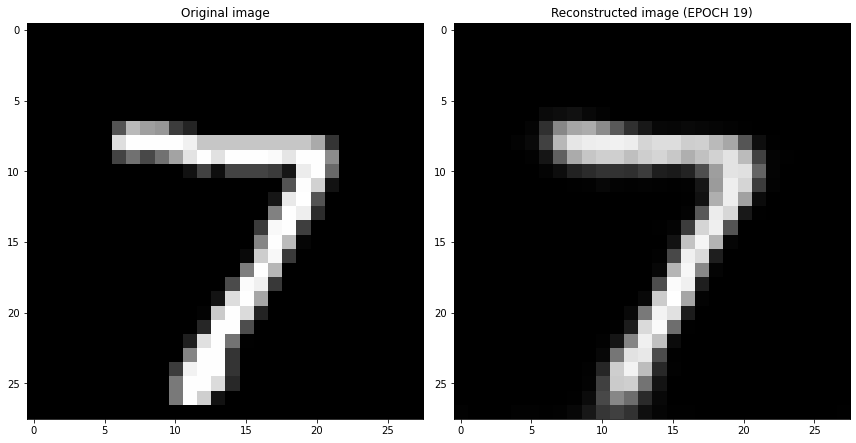

	 TRAIN - EPOCH 20/50 - loss: 0.015316
	 VALIDATION - EPOCH 20/50 - loss: 0.016454


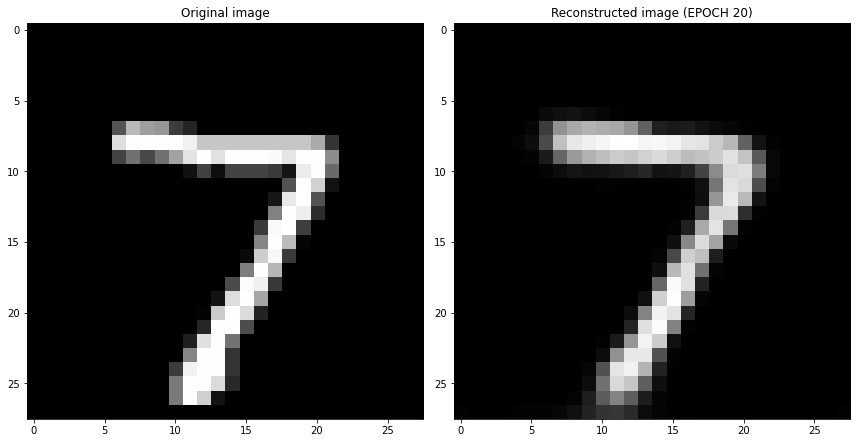

	 TRAIN - EPOCH 21/50 - loss: 0.016691
	 VALIDATION - EPOCH 21/50 - loss: 0.016336


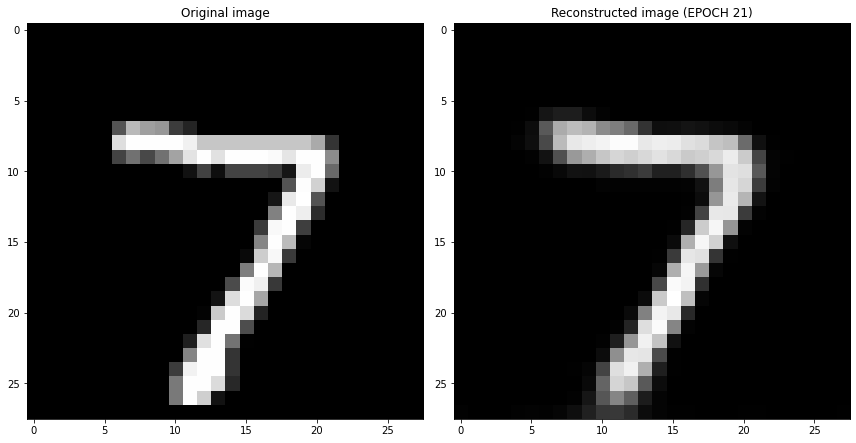

	 TRAIN - EPOCH 22/50 - loss: 0.017182
	 VALIDATION - EPOCH 22/50 - loss: 0.016162


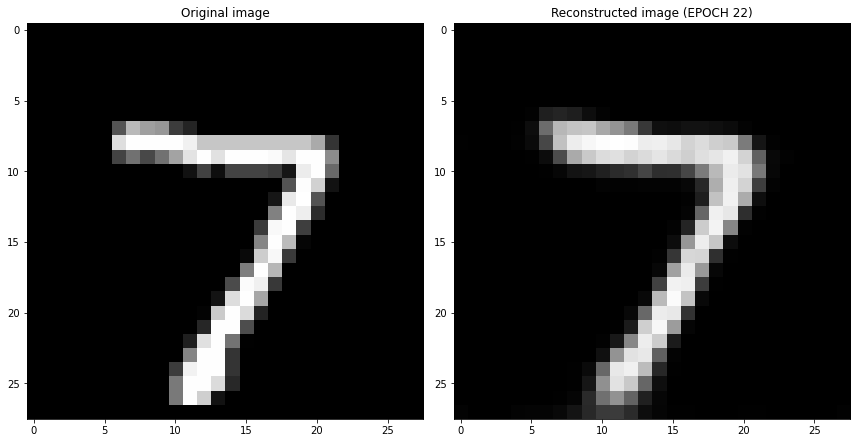

	 TRAIN - EPOCH 23/50 - loss: 0.016654
	 VALIDATION - EPOCH 23/50 - loss: 0.015954


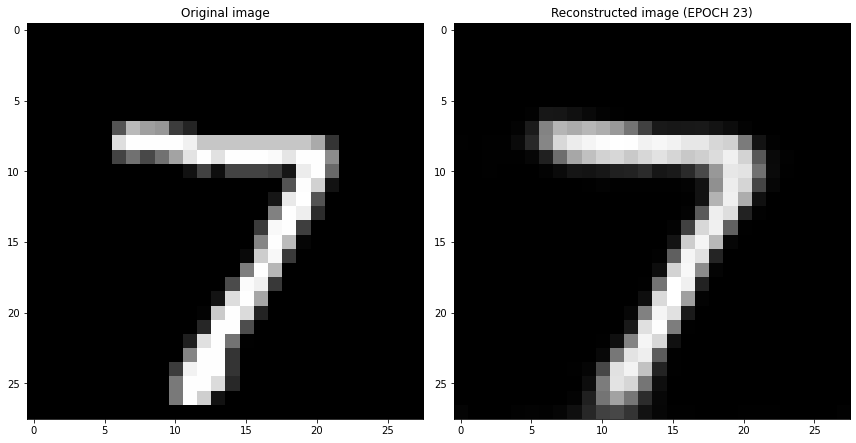

	 TRAIN - EPOCH 24/50 - loss: 0.014667
	 VALIDATION - EPOCH 24/50 - loss: 0.015782


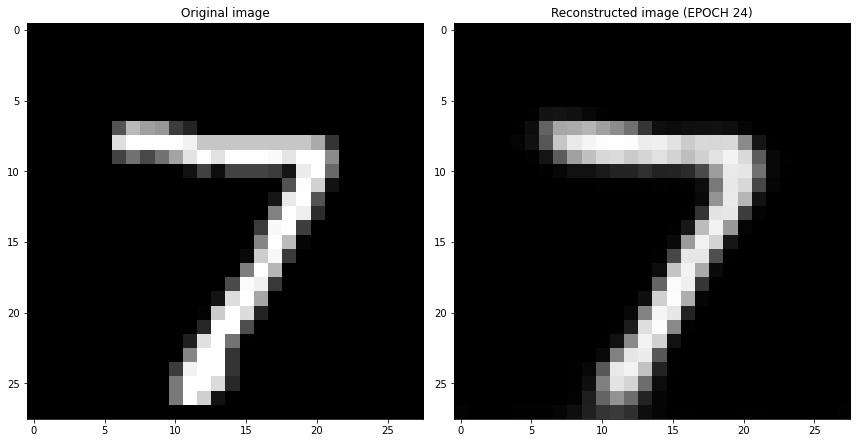

	 TRAIN - EPOCH 25/50 - loss: 0.015640
	 VALIDATION - EPOCH 25/50 - loss: 0.015653


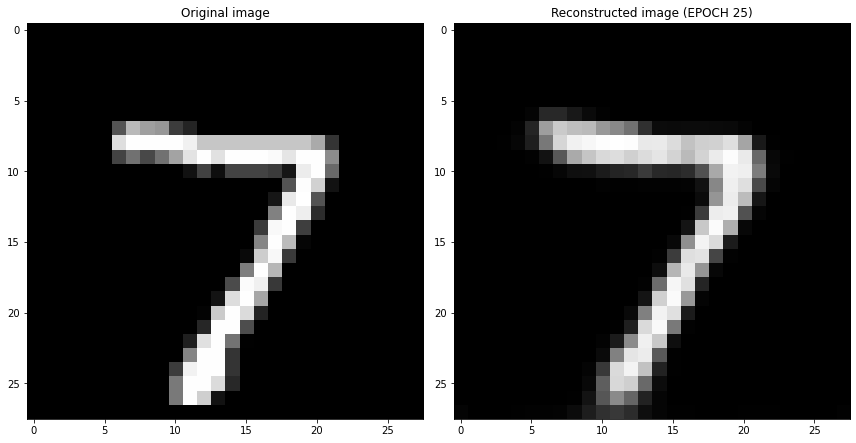

STOPPED BY EARLY STOPPYNG
	Train Loss: 0.016 	Val Loss: 0.016


Best Model: (10, 8, 16, 32, 64, 0.001, 1e-05)


In [14]:
"""
Hyperparams:
encoded_space_dim = [2, 4, 128]
num_epochs=50
early_stopping=5
Conv1=[8,16,32,64]
Conv2=[8,16,32,64]
Conv3=[8,16,32,64]
FC=[32,64,128]
LR=[1e-2,1e-3,1e-4]
L2=[1e-3,1e-4,1e-5]
drop=[0,0.25,0.5,0.75]

"""

space_dim = [10]
num_epochs=50
early_stopping=5
Conv1=[8]
Conv2=[16]
Conv3=[32]
FC=[64]
LR=[1e-3]
L2=[1e-5]
drop=0


hyperparams = [space_dim,Conv1,Conv2,Conv3,FC,LR,L2]  

iterations=[]
import itertools
for hyper in itertools.product(*hyperparams):
    iterations.append(hyper)
print("Total Combinations:",len(iterations))


best_hyper=None
best_loss=None
for i,hyper in enumerate(iterations):
    print("\n\nIteration:",i,hyper)
    encoded_space_dim,conv1,conv2,conv3,fc,lr,l2=hyper
    
    ### Initialize the two networks
    encoder = Encoder(encoded_space_dim=encoded_space_dim,dropout=drop, conv1=conv1,conv2=conv2,conv3=conv3,fc=fc)
    decoder = Decoder(encoded_space_dim=encoded_space_dim,dropout=drop, conv1=conv1,conv2=conv2,conv3=conv3,fc=fc)

    # Define the loss function
    loss_fn = torch.nn.MSELoss()

    ### Define an optimizer (both for the encoder and the decoder!)
    params_to_optimize = [
        {'params': encoder.parameters()},
        {'params': decoder.parameters()}
    ]
    optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=l2)

    # Move both the encoder and the decoder to the selected device
    encoder.to(device)
    decoder.to(device)
    
    
    #TRAINING CYCLE
    train_loss_log,val_loss_log=training_cycle(num_epochs,
                                           early_stopping,
                                           encoder,
                                           decoder,
                                           loss_fn,
                                           optim,
                                           train_dataloader,
                                           device,
                                           test_dataset,
                                            noise=False)
    train_loss=train_loss_log[-1]
    val_loss=val_loss_log[-1]
    print("\tTrain Loss:",round(float(train_loss),3),"\tVal Loss:",round(float(val_loss),3))
    
    if not best_loss or val_loss<best_loss:
        best_loss=val_loss
        best_hyper=hyper

        
print("\n\nBest Model:",best_hyper)

## 3.3) Single train

In [ ]:
# Retrain the best model
if best_hyper:
    encoded_space_dim,conv1,conv2,conv3,fc,lr,l2=best_hyper
    print("Training:",best_hyper)


### Initialize the two networks
encoder = Encoder(encoded_space_dim=encoded_space_dim,dropout=drop, conv1=conv1,conv2=conv2,conv3=conv3,fc=fc)
decoder = Decoder(encoded_space_dim=encoded_space_dim,dropout=drop, conv1=conv1,conv2=conv2,conv3=conv3,fc=fc)

# Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=l2)

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)
    
    
train_loss_log,val_loss_log=training_cycle(num_epochs,
                                           early_stopping,
                                           encoder,
                                           decoder,
                                           loss_fn,
                                           optim,
                                           train_dataloader,
                                           device,
                                           test_dataset,
                                           noise=False)

## 3.4) Plot Losses

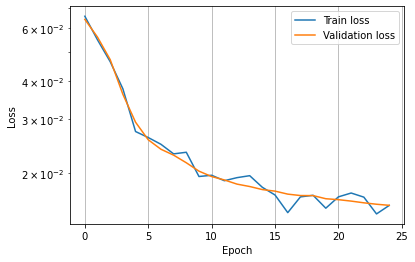

In [17]:
# Plot losses of the best model
plt.figure(figsize=(6,4))
plt.semilogy(train_loss_log, label='Train loss')
plt.semilogy(val_loss_log, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

## 3.5) Metric Summary

In [18]:
train_loss=train_loss_log[-1]
val_loss=val_loss_log[-1]
print("Train Loss:\t",round(float(train_loss),3))
print("Val Loss:\t",round(float(val_loss),3))

Train Loss:	 0.016
Val Loss:	 0.016


# 4) Latent Space Visualization and Sample Generation

## 4.1) Latent Space Visualization with T-SNE

In [19]:
# Load network parameters
encoder.load_state_dict(torch.load('encoder_params.pth'))
decoder.load_state_dict(torch.load('decoder_params.pth'))

<All keys matched successfully>

In [21]:
### Get the encoded representation of the test samples
encoded_samples = []
labels=[]
for sample in tqdm(test_dataset):
    img = sample[0][0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_samples.append(encoded_img)
    labels.append(str(label))

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 876.93it/s]


In [22]:
from sklearn import manifold
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(encoded_samples)

In [ ]:
#Plot
#plt.scatter(X_tsne[:,0],X_tsne[:,1],c=labelsint)
#plt.show()

In [23]:
import plotly.express as px
px.scatter(x=X_tsne[:,0], y=X_tsne[:,1], color=labels, opacity=0.7)

## 4.2) Sample Generation

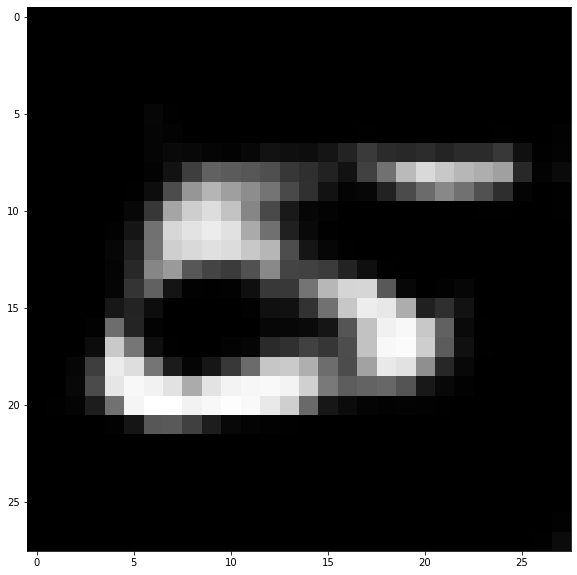

In [24]:
if encoded_space_dim == 10:
    # Generate a custom sample
    custom_encoded_sample = [-12,-28,-30,-5,-31,6,7,8,9,10]
    encoded_value = torch.tensor(custom_encoded_sample).float().unsqueeze(0).to(device)

    # Decode sample
    decoder.eval()
    with torch.no_grad():
        generated_img  = decoder(encoded_value)

    plt.figure(figsize=(12,10))
    plt.imshow(generated_img.squeeze().cpu().numpy(), cmap='gist_gray')
    plt.show()

In [ ]:
#........................................

---
---
---
# 5) Denoising Autoencoder

In [31]:
def gaussian_noise(image, noise_factor):
    
    # torch.randn returns random values from a normal with mean 0 and variance 1 -> Gaussian noise!
    noisy_img = image + noise_factor * torch.randn(image.shape)
    #clip the image
    noisy_img = np.clip(noisy_img, 0., 1.)
    
    return noisy_img

## 5.1) Plot some Corrupted images and Recostruction with the normal ConvAE

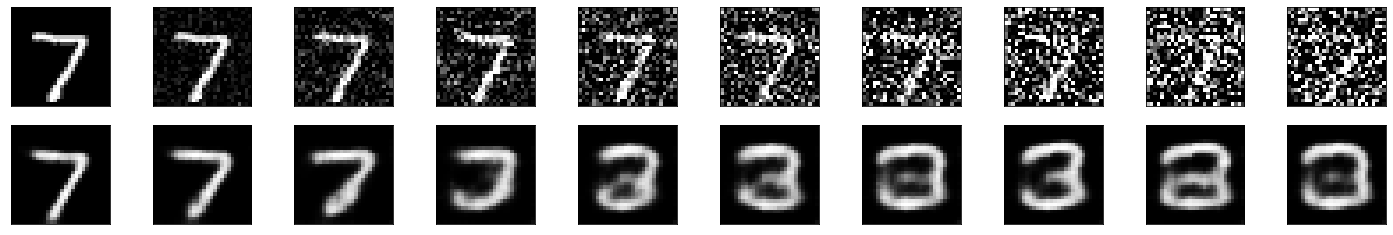

In [32]:
corr_imgs, rec_imgs  = [], []

for i in range(10):
    imgc = test_dataset[0][0][0].unsqueeze(0)
    corr_imgs.append(gaussian_noise(imgc, 0.1*i))

for i in range(len(corr_imgs)):
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Move tensor to the proper device
        image_batch = corr_imgs[i].to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Append the network output and the original image to the lists
        rec_imgs.append(decoded_data.cpu())

        
# plot the corrupted input image and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))
# input images on top row, reconstructions on bottom
for corr_imgs, row in zip([corr_imgs, rec_imgs], axes):
    for img, ax in zip(corr_imgs, row):
        
        ax.imshow(img.squeeze().cpu().numpy(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

## 5.2) Train the Denoise AutoEncoder

	 TRAIN - EPOCH 1/50 - loss: 0.063922
	 VALIDATION - EPOCH 1/50 - loss: 0.064962


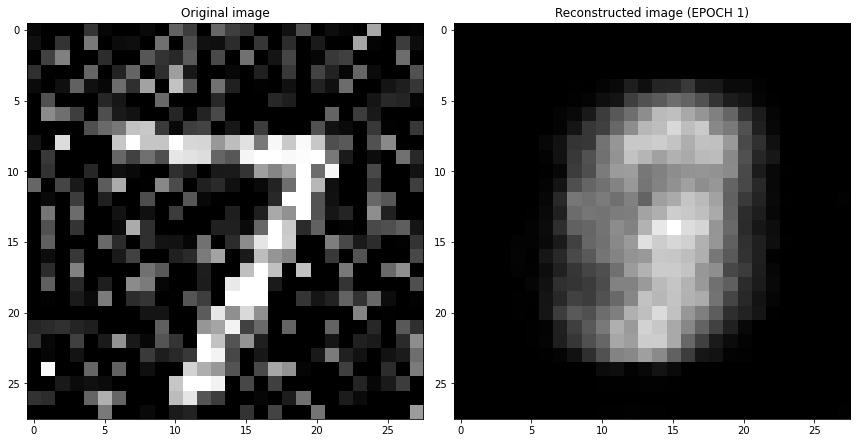

	 TRAIN - EPOCH 2/50 - loss: 0.058366
	 VALIDATION - EPOCH 2/50 - loss: 0.056731


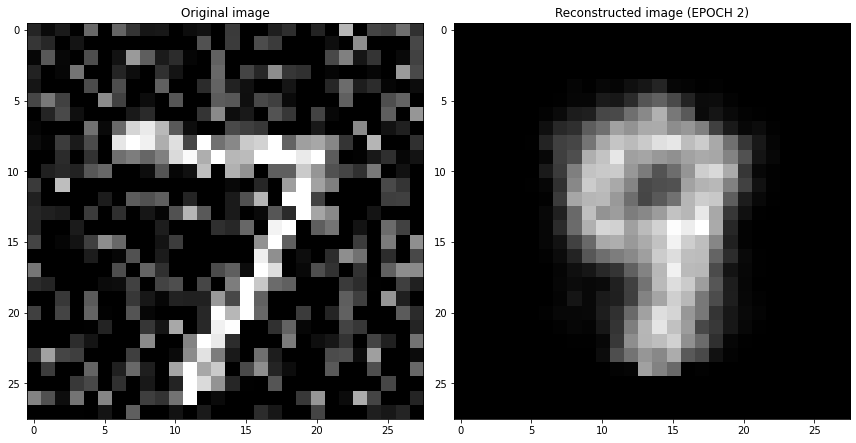

	 TRAIN - EPOCH 3/50 - loss: 0.050374
	 VALIDATION - EPOCH 3/50 - loss: 0.047962


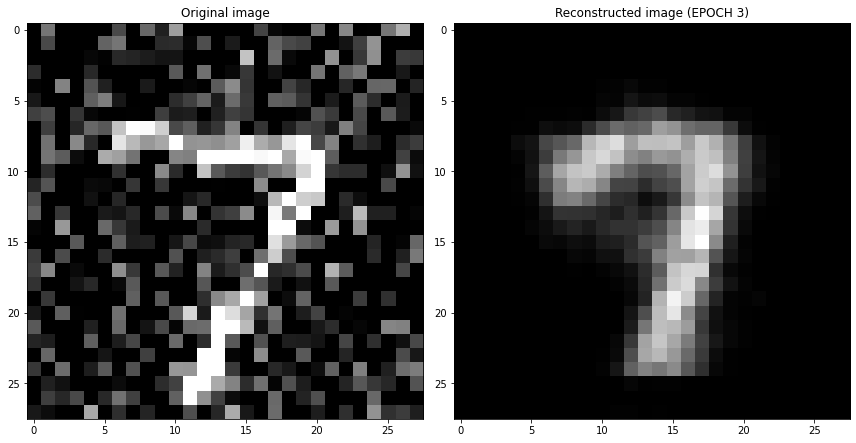

	 TRAIN - EPOCH 4/50 - loss: 0.037205
	 VALIDATION - EPOCH 4/50 - loss: 0.038510


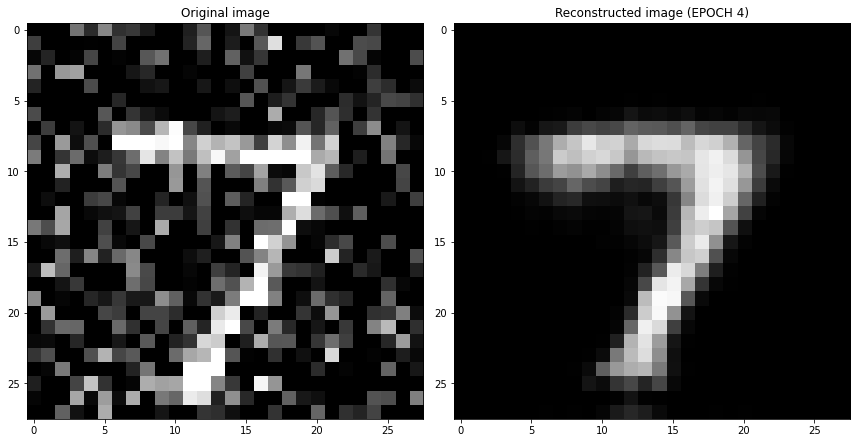

	 TRAIN - EPOCH 5/50 - loss: 0.032084
	 VALIDATION - EPOCH 5/50 - loss: 0.031727


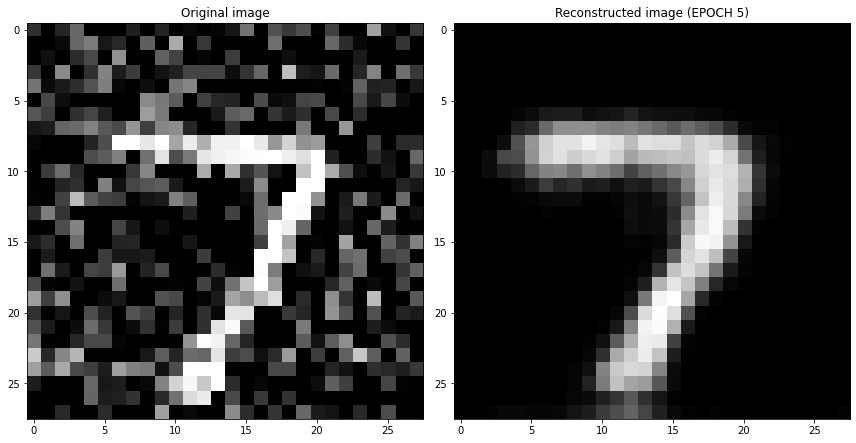

	 TRAIN - EPOCH 6/50 - loss: 0.030836
	 VALIDATION - EPOCH 6/50 - loss: 0.029053


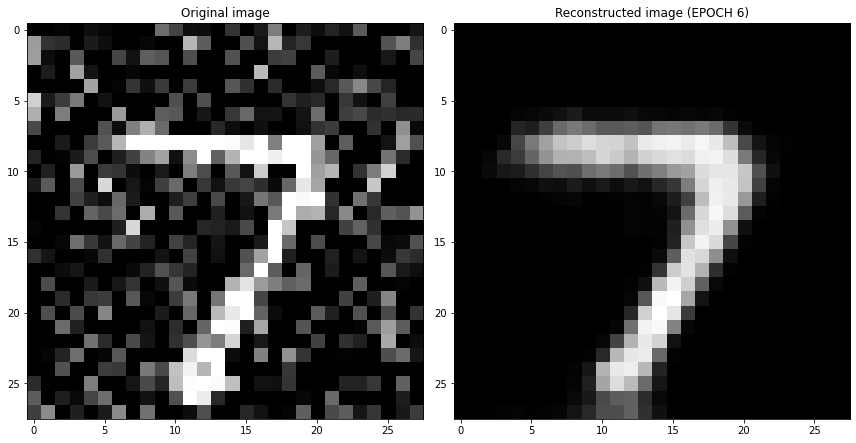

	 TRAIN - EPOCH 7/50 - loss: 0.027517
	 VALIDATION - EPOCH 7/50 - loss: 0.026523


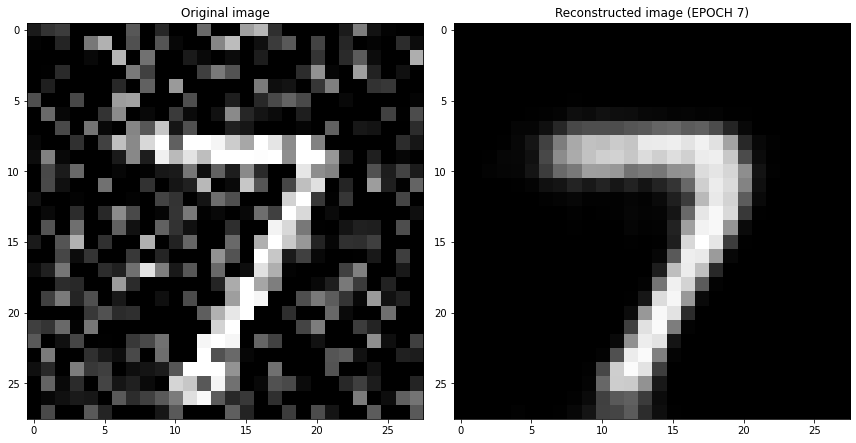

	 TRAIN - EPOCH 8/50 - loss: 0.024588
	 VALIDATION - EPOCH 8/50 - loss: 0.024505


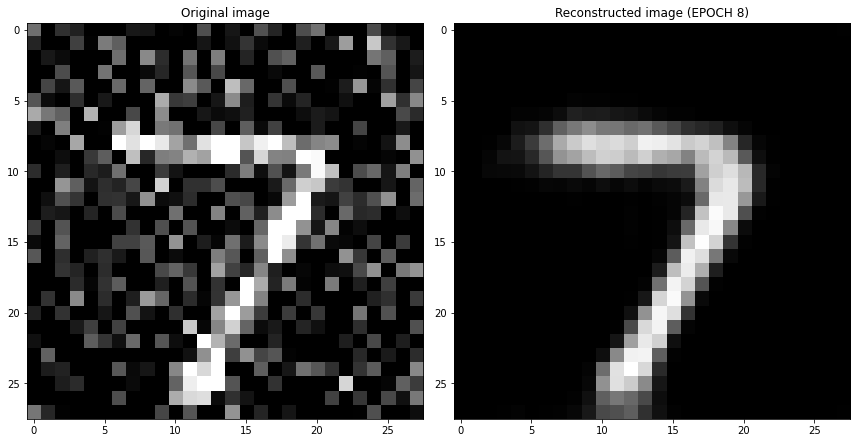

	 TRAIN - EPOCH 9/50 - loss: 0.023568
	 VALIDATION - EPOCH 9/50 - loss: 0.023266


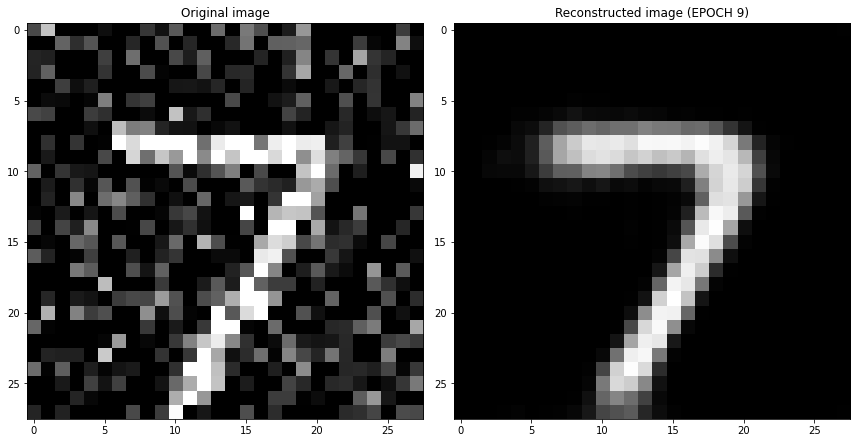

	 TRAIN - EPOCH 10/50 - loss: 0.022094
	 VALIDATION - EPOCH 10/50 - loss: 0.021896


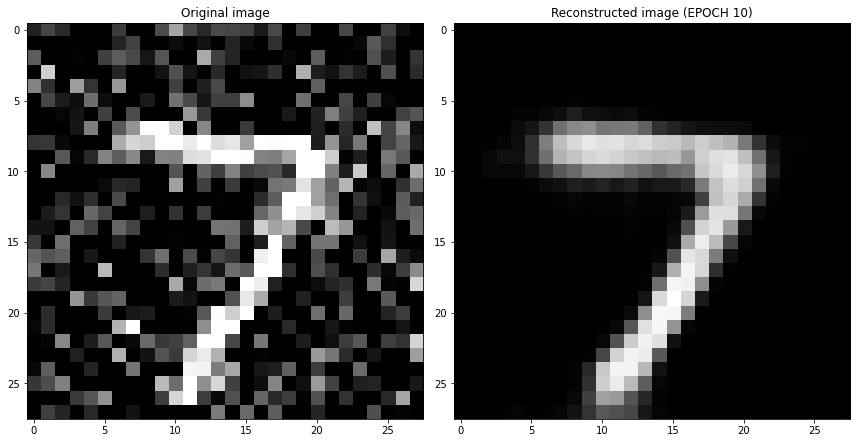

	 TRAIN - EPOCH 11/50 - loss: 0.018625
	 VALIDATION - EPOCH 11/50 - loss: 0.020827


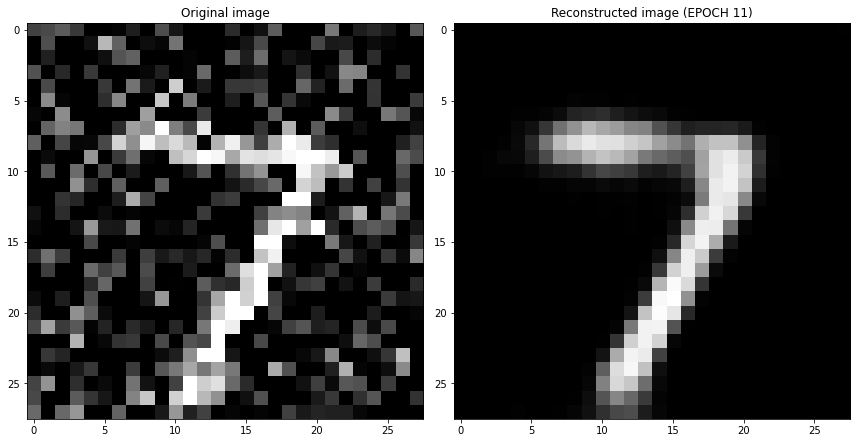

	 TRAIN - EPOCH 12/50 - loss: 0.020440
	 VALIDATION - EPOCH 12/50 - loss: 0.020259


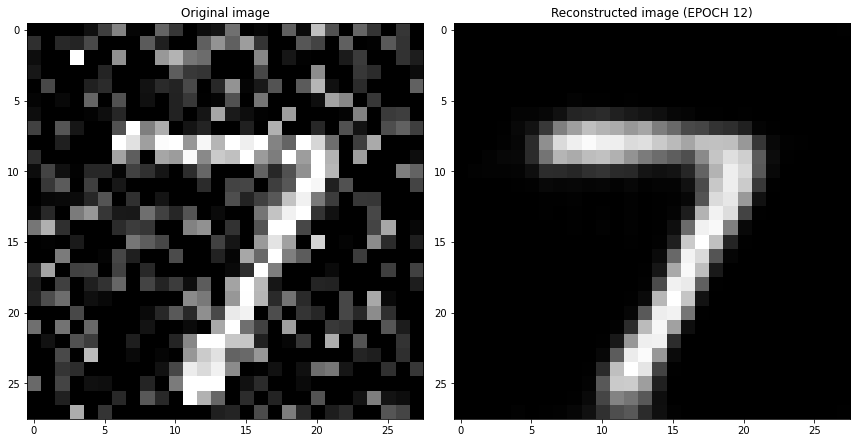

	 TRAIN - EPOCH 13/50 - loss: 0.019789
	 VALIDATION - EPOCH 13/50 - loss: 0.019999


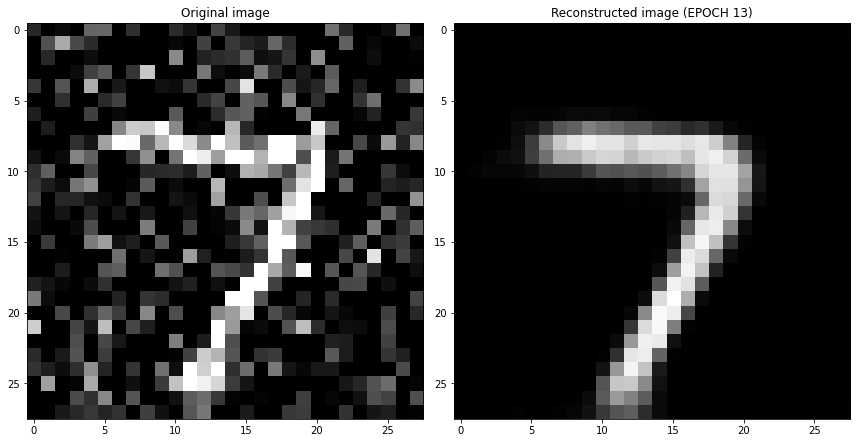

	 TRAIN - EPOCH 14/50 - loss: 0.021418
	 VALIDATION - EPOCH 14/50 - loss: 0.019432


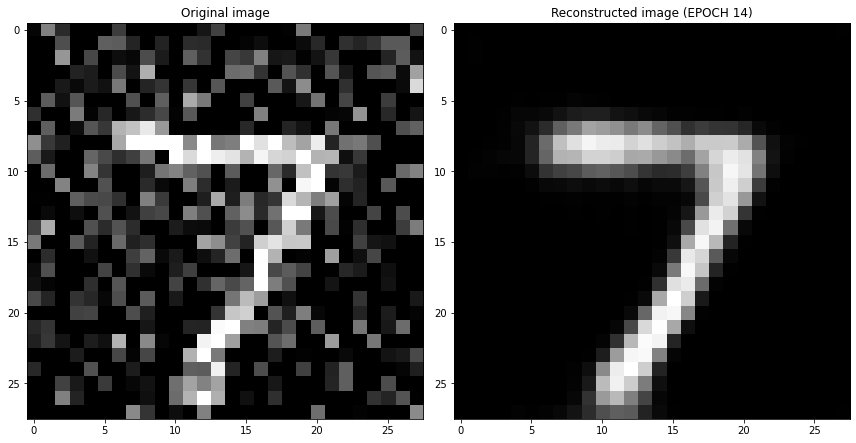

	 TRAIN - EPOCH 15/50 - loss: 0.018051
	 VALIDATION - EPOCH 15/50 - loss: 0.019063


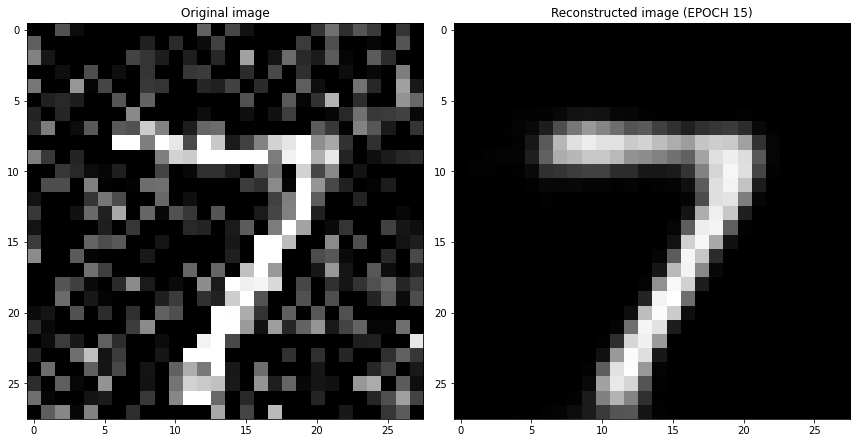

	 TRAIN - EPOCH 16/50 - loss: 0.019444
	 VALIDATION - EPOCH 16/50 - loss: 0.018914


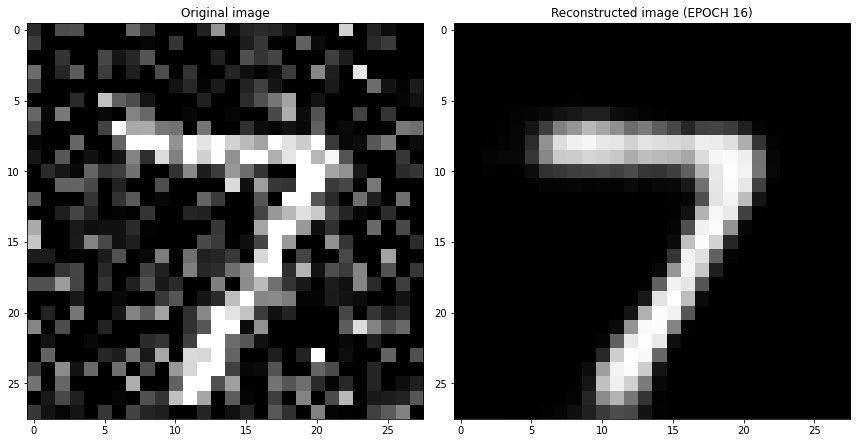

	 TRAIN - EPOCH 17/50 - loss: 0.017928
	 VALIDATION - EPOCH 17/50 - loss: 0.018602


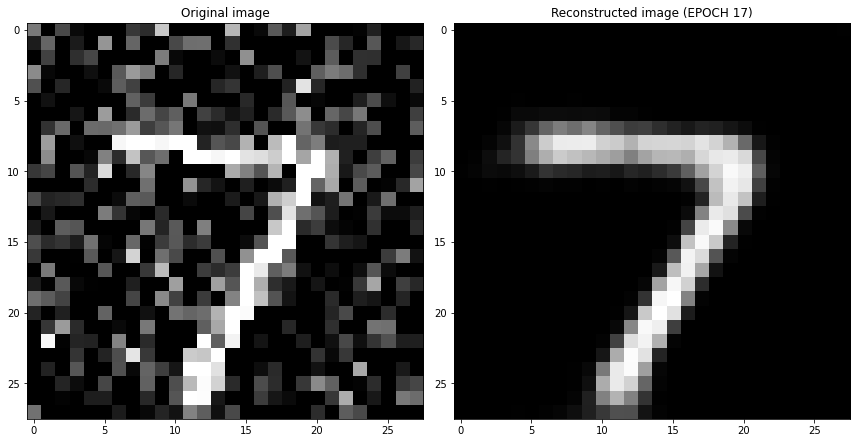

	 TRAIN - EPOCH 18/50 - loss: 0.020074
	 VALIDATION - EPOCH 18/50 - loss: 0.018435


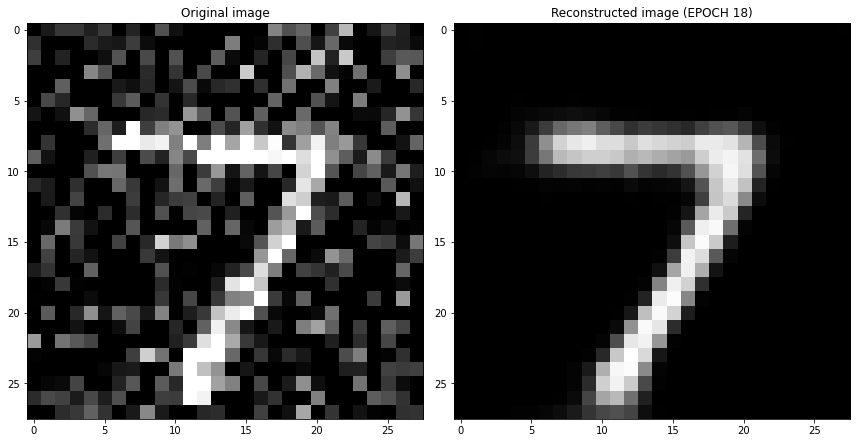

	 TRAIN - EPOCH 19/50 - loss: 0.018546
	 VALIDATION - EPOCH 19/50 - loss: 0.018267


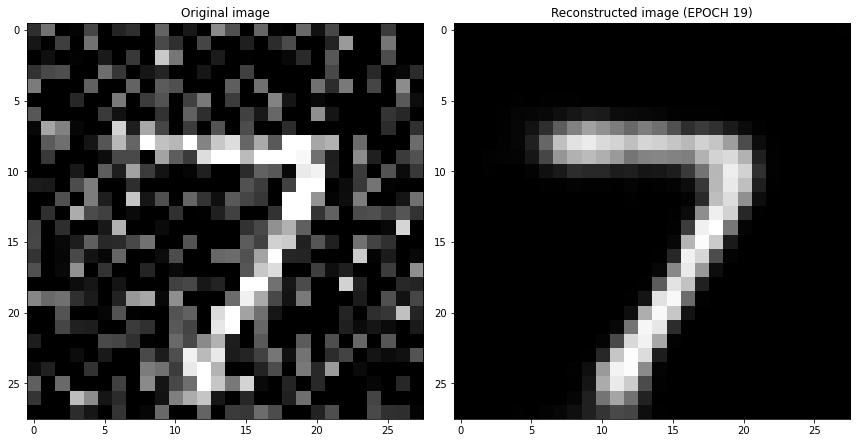

	 TRAIN - EPOCH 20/50 - loss: 0.016853
	 VALIDATION - EPOCH 20/50 - loss: 0.018057


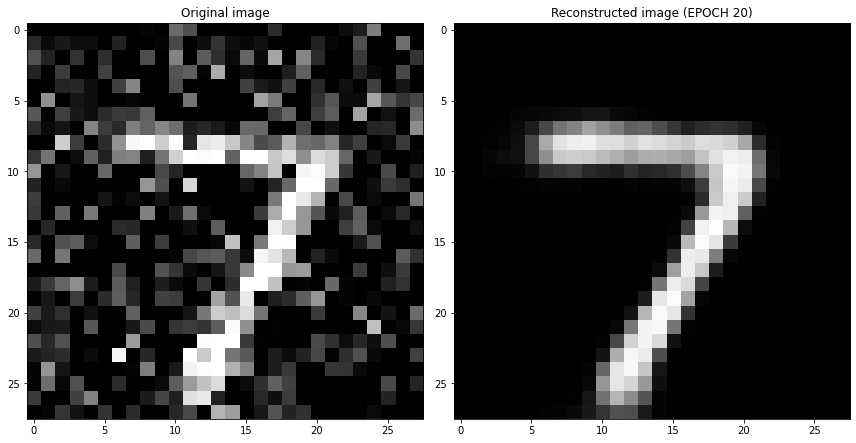

	 TRAIN - EPOCH 21/50 - loss: 0.017463
	 VALIDATION - EPOCH 21/50 - loss: 0.017726


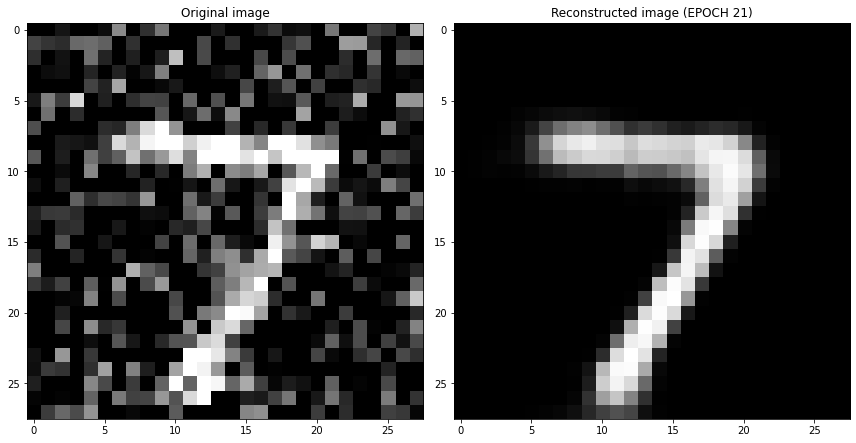

	 TRAIN - EPOCH 22/50 - loss: 0.018338
	 VALIDATION - EPOCH 22/50 - loss: 0.017747


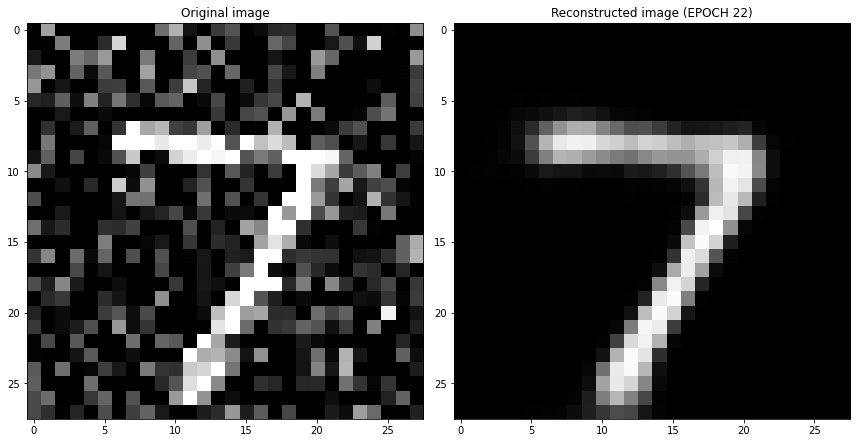

	 TRAIN - EPOCH 23/50 - loss: 0.016947
	 VALIDATION - EPOCH 23/50 - loss: 0.017596


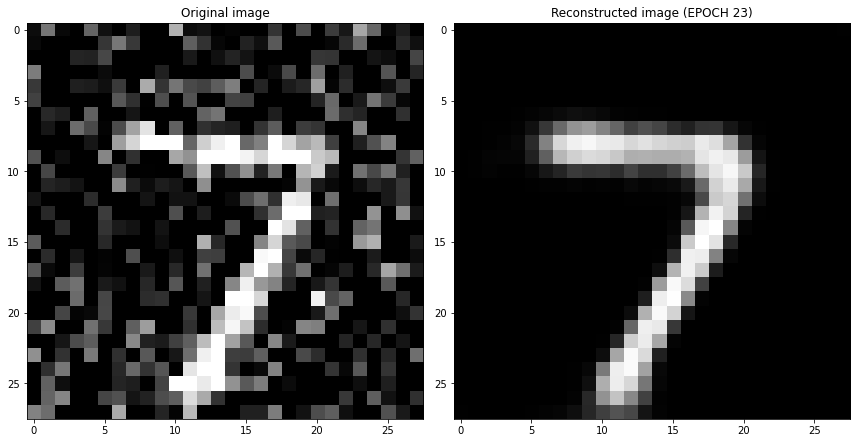

STOPPED BY EARLY STOPPYNG


In [39]:
# Retrain the best model
"""if best_hyper:
    encoded_space_dim,conv1,conv2,conv3,fc,lr,l2=best_hyper
    print("Training:",best_hyper)"""

encoded_space_dim = 10
num_epochs=50
early_stopping=5
conv1=8
conv2=16
conv3=32
fc=64
lr=1e-3
l2=1e-5
drop=0

### Initialize the two networks
encoder = Encoder(encoded_space_dim=encoded_space_dim,dropout=drop, conv1=conv1,conv2=conv2,conv3=conv3,fc=fc)
decoder = Decoder(encoded_space_dim=encoded_space_dim,dropout=drop, conv1=conv1,conv2=conv2,conv3=conv3,fc=fc)

# Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=l2)

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)
    
    
train_loss_log,val_loss_log=training_cycle(num_epochs,
                                           early_stopping,
                                           encoder,
                                           decoder,
                                           loss_fn,
                                           optim,
                                           train_dataloader,
                                           device,
                                           test_dataset,
                                           noise=True)

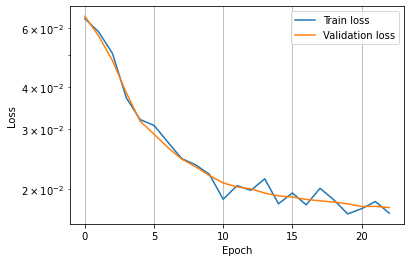

In [40]:
# Plot losses of the best model
plt.figure(figsize=(6,4))
plt.semilogy(train_loss_log, label='Train loss')
plt.semilogy(val_loss_log, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

In [41]:
train_loss=train_loss_log[-1]
val_loss=val_loss_log[-1]
print("Train Loss:\t",round(float(train_loss),3))
print("Val Loss:\t",round(float(val_loss),3))

Train Loss:	 0.017
Val Loss:	 0.018


## 5.3) Plot some Corrupted images and Recostruction with the Denoise ConvAE

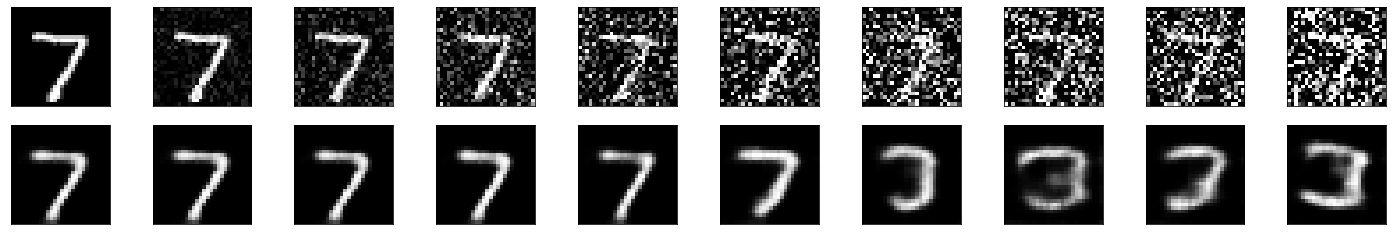

In [42]:
corr_imgs, rec_imgs  = [], []

for i in range(10):
    imgc = test_dataset[0][0][0].unsqueeze(0)
    corr_imgs.append(gaussian_noise(imgc, 0.1*i))

for i in range(len(corr_imgs)):
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Move tensor to the proper device
        image_batch = corr_imgs[i].to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Append the network output and the original image to the lists
        rec_imgs.append(decoded_data.cpu())

        
# plot the corrupted input image and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))
# input images on top row, reconstructions on bottom
for corr_imgs, row in zip([corr_imgs, rec_imgs], axes):
    for img, ax in zip(corr_imgs, row):
        
        ax.imshow(img.squeeze().cpu().numpy(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

---
---
---
---
# 6) Supervised Classification

In [19]:
print(encoder)

Encoder(
  (encoder_cnn): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Dropout2d(p=0, inplace=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): Dropout2d(p=0, inplace=False)
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (7): ReLU(inplace=True)
    (8): Dropout2d(p=0, inplace=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder_lin): Sequential(
    (0): Linear(in_features=288, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0, inplace=False)
    (3): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [20]:
outputLayer = nn.Linear(encoded_space_dim, 10)
outputLayer = outputLayer.to(device)

In [21]:
loss_fn = torch.nn.CrossEntropyLoss()

### Define an optimizer (both for the encoder and the decoder!)
lr = 1e-3 # Learning rate
params_to_optimize = [
    {'params': outputLayer.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-5)

In [22]:
from sklearn.metrics import confusion_matrix
num_epochs = 40
train_accuracy_log = []
val_accuracy_log = []
sig = nn.Sigmoid()

for epoch in range(num_epochs):
    print('EPOCH %d/%d' % (epoch + 1, num_epochs))
    train_pred = []
    val_pred = []
    for image_batch in train_dataloader:
      image = image_batch[0][0].to(device)
      label = image_batch[1].to(device)

      encoded = encoder(image)
      output = outputLayer(encoded)

      loss = loss_fn(output, label)
      outputLayer.zero_grad()
      loss.backward()
      optim.step()

      prediction = torch.argmax(sig(output), dim=1)
      
      accuracy = np.trace(confusion_matrix(prediction.cpu(), label.cpu())) / 100#(prediction == label).int().sum().item() / image.shape[0]
      train_pred.append(accuracy)

    with torch.no_grad():
      for image_batch in val_dataloader:
        image = image_batch[0].to(device)
        label = image_batch[1].to(device)

        encoded = encoder(image)
        output = outputLayer(encoded)

        prediction = torch.argmax(sig(output), dim=1)
        accuracy = (prediction == label).int().sum().item() / image.shape[0]
        val_pred.append(accuracy)

    
    train_pred = np.mean(train_pred)
    print(f"AVERAGE TRAIN ACCURACY: {train_pred * 100}%")
    train_accuracy_log.append(train_pred)

    val_pred = np.mean(val_pred)
    print(f"AVERAGE VALIDATION ACCURACY: {val_pred * 100}%")
    val_accuracy_log.append(val_pred)

EPOCH 1/40


NameError: name 'val_dataloader' is not defined

In [ ]:
plt.figure(figsize=(12,8))
plt.semilogy(train_accuracy_log, label='Train accuracy')
plt.semilogy(val_accuracy_log, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

In [ ]:
accuracy_tot = []
with torch.no_grad():
  for batch_image in test_dataloader:
    images = batch_image[0][0].to(device)
    labels = batch_image[1].to(device)

    encoded = encoder(images)
    output = outputLayer(encoded)

    prediction = torch.argmax(sig(output), dim=1)

    accuracy = np.trace(confusion_matrix(prediction.cpu(), labels.cpu())) / 100
    accuracy_tot.append(accuracy)
  accuracy = np.mean(accuracy_tot)
  print(f"AVERAGE TEST ACCURACY: {accuracy}%")

In [ ]:
confusion_matrix(prediction.cpu(), labels.cpu())

---
---
---
---
# 7) Variational Autoencoder

## 7.1) Model

In [43]:
import torch.nn.functional as F

In [44]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)
        
    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return F.sigmoid(self.fc6(h)) 
    
    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

# build model
vae = VAE(x_dim=784, h_dim1= 512, h_dim2=256, z_dim=2)
if torch.cuda.is_available():
    vae.cuda()

In [45]:
vae

VAE(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc31): Linear(in_features=256, out_features=2, bias=True)
  (fc32): Linear(in_features=256, out_features=2, bias=True)
  (fc4): Linear(in_features=2, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=784, bias=True)
)

## 7.2) Train

In [50]:
optimizer = torch.optim.Adam(vae.parameters())
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [51]:
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_dataloader):
        data = data[0].cuda()
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = vae(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_dataloader.dataset),
                100. * batch_idx / len(train_dataloader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_dataloader.dataset)))

In [52]:
def test():
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in test_dataloader:
            data = data[0].cuda()
            recon, mu, log_var = vae(data)
            
            # sum up batch loss
            test_loss += loss_function(recon, data, mu, log_var).item()
        
    test_loss /= len(test_dataloader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [53]:
for epoch in range(1, 51):
    train(epoch)
    test()

C:\Users\stefano\.conda\envs\gputest\lib\site-packages\torch\nn\functional.py:1639: UserWarning:

nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.



Train Epoch: 1 [0/60000 (0%)]	Loss: 546.276428
Train Epoch: 1 [25600/60000 (43%)]	Loss: 186.819199
Train Epoch: 1 [51200/60000 (85%)]	Loss: 174.027054
====> Epoch: 1 Average loss: 200.7268
====> Test set loss: 172.3056
Train Epoch: 2 [0/60000 (0%)]	Loss: 169.845154
Train Epoch: 2 [25600/60000 (43%)]	Loss: 165.807648
Train Epoch: 2 [51200/60000 (85%)]	Loss: 161.769608
====> Epoch: 2 Average loss: 165.2221
====> Test set loss: 160.7538
Train Epoch: 3 [0/60000 (0%)]	Loss: 156.590576
Train Epoch: 3 [25600/60000 (43%)]	Loss: 158.849014
Train Epoch: 3 [51200/60000 (85%)]	Loss: 152.253967
====> Epoch: 3 Average loss: 157.8900
====> Test set loss: 155.7554
Train Epoch: 4 [0/60000 (0%)]	Loss: 155.706039
Train Epoch: 4 [25600/60000 (43%)]	Loss: 150.234909
Train Epoch: 4 [51200/60000 (85%)]	Loss: 154.842896
====> Epoch: 4 Average loss: 153.9919
====> Test set loss: 152.6714
Train Epoch: 5 [0/60000 (0%)]	Loss: 147.204834
Train Epoch: 5 [25600/60000 (43%)]	Loss: 157.862915
Train Epoch: 5 [51200/600

Train Epoch: 38 [25600/60000 (43%)]	Loss: 133.123840
Train Epoch: 38 [51200/60000 (85%)]	Loss: 133.327713
====> Epoch: 38 Average loss: 136.8423
====> Test set loss: 139.8356
Train Epoch: 39 [0/60000 (0%)]	Loss: 139.795029
Train Epoch: 39 [25600/60000 (43%)]	Loss: 137.923798
Train Epoch: 39 [51200/60000 (85%)]	Loss: 133.653412
====> Epoch: 39 Average loss: 136.6699
====> Test set loss: 139.2944
Train Epoch: 40 [0/60000 (0%)]	Loss: 138.999603
Train Epoch: 40 [25600/60000 (43%)]	Loss: 137.421677
Train Epoch: 40 [51200/60000 (85%)]	Loss: 138.624420
====> Epoch: 40 Average loss: 136.5853
====> Test set loss: 139.6682
Train Epoch: 41 [0/60000 (0%)]	Loss: 135.946487
Train Epoch: 41 [25600/60000 (43%)]	Loss: 143.375763
Train Epoch: 41 [51200/60000 (85%)]	Loss: 133.998474
====> Epoch: 41 Average loss: 136.5112
====> Test set loss: 139.9345
Train Epoch: 42 [0/60000 (0%)]	Loss: 134.080017
Train Epoch: 42 [25600/60000 (43%)]	Loss: 139.355042
Train Epoch: 42 [51200/60000 (85%)]	Loss: 138.595551
==

## 7.3) Generate some samples from the VAE

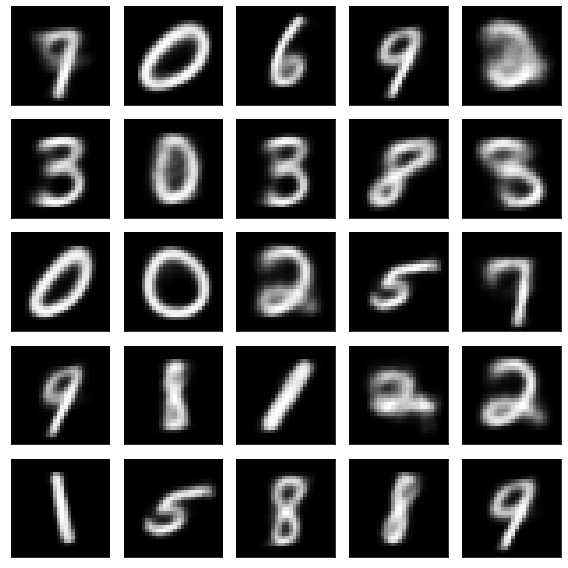

In [56]:
### Plot some sample
fig, axs = plt.subplots(5, 5, figsize=(8,8))
for ax in axs.flatten():
    with torch.no_grad():
        z = torch.randn(1, 2).cuda()
        sample = vae.decoder(z).cuda()
    sample=sample.view(1, 1, 28, 28)[0].cpu().squeeze().numpy()
    
    ax.imshow(sample, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()